#  Predicting the worlds offline population
## First Model Training and Evaluation 
## (Random Forest on Brazil)

In [119]:
# load libraries
import yaml
import lightgbm
import matplotlib.pyplot as plt
import pandas as pd
import geopandas
import numpy as np
import plotly.figure_factory as ff
import plotly.express as px
from sklearn.model_selection import train_test_split, KFold, RandomizedSearchCV, GridSearchCV
from sklearn.ensemble import RandomForestRegressor

### Load and prepare data

In [47]:
import os
import pandas as pd

#you will need to reset this to your own working directory
os.chdir('/home/desktop3')
path = os.getcwd()
print(path)

/home/desktop3


In [70]:
# read in (yaml) configs
with open(path + '/itu/conf/model_config.yaml', 'r') as conf:
    model_config = yaml.safe_load(conf)
    
# import data
dataset = path + model_config['model']['loc'] + model_config['model']['file']
dataset = pd.read_csv(dataset)
# subset for faster trial and error
#dataset = dataset.iloc[0:1000,:]

# define predictors and target
predictor   =  model_config['meta']['predictors']
target = model_config['meta']['target']

In [71]:
#All the columns available
dataset.columns

Index(['source_school_id', 'latitude', 'longitude', 'school_location',
       'geometry', 'target', 'mean_ghm', 'mean_avg_rad', 'change_year_avg_rad',
       'slope_year_avg_rad', 'change_month_avg_rad', 'slope_month_avg_rad',
       'mean_cf_cvg', 'change_year_cf_cvg', 'slope_year_cf_cvg',
       'change_month_cf_cvg', 'slope_month_cf_cvg', 'mean_NDVI',
       'change_year_NDVI', 'slope_year_NDVI', 'change_month_NDVI',
       'slope_month_NDVI', 'estimate_dau', 'estimate_mau', 'estimate_ready',
       'range', 'avg_d_kbps', 'avg_u_kbps', 'population'],
      dtype='object')

In [72]:
#Let's peek at the data table
dataset.head(n=3)

source_school_id  latitude  longitude                      school_location  \
0          11000023   -8.7585   -63.8540              POINT (-63.854 -8.7585)   
1          11001364   -8.7627   -63.8642  POINT (-63.8642 -8.762700000000001)   
2          11003138   -8.7579   -63.8554  POINT (-63.8554 -8.757899999999999)   

                                            geometry  target  mean_ghm  \
0  POLYGON ((-63.844 -8.7585, -63.84404815273328 ...     1.0  0.778150   
1  POLYGON ((-63.8542 -8.762700000000001, -63.854...     1.0  0.813903   
2  POLYGON ((-63.84540000000001 -8.75789999999999...     1.0  0.781545   

   mean_avg_rad  change_year_avg_rad  slope_year_avg_rad  ...  \
0     29.486260             1.040262            0.173377  ...   
1     32.686109            -0.064534           -0.010756  ...   
2     29.852872             0.962008            0.160335  ...   

   slope_year_NDVI  change_month_NDVI  slope_month_NDVI  estimate_dau  \
0        23.184182         352.089866          2.551376        180872   
1        24.580166         336.748641          2.440208        189483   
2        23.466914         356.627458          2.584257        180714   

   estimate_mau  estimate_ready  range  avg_d_kbps  avg_u_kbps  population  
0        270000            True    1.0    111541.0     41429.0   21621.277  
1        280000            True    1.0     19693.0     16480.0   25260.330  
2        270000            True    1.0    111541.0     41429.0   32302.738  

[3 rows x 29 columns]

In [73]:
# prepare data
X = dataset[predictor]
y = dataset[target]
print('X Shape:', X.shape)
print('y Shape:', y.shape)
   
# Train/Test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = model_config['parameter']['test_size'], 
                                                    random_state = 42)

print('X_train, X_test, y_train, y_test shapes:', X_train.shape, X_test.shape, y_train.shape, y_test.shape)
print("size of training dataset = ", len(X_train))
print("size of test dataset = ", len(X_test))

X Shape: (11732, 12)
y Shape: (11732, 1)
X_train, X_test, y_train, y_test shapes: (8212, 12) (3520, 12) (8212, 1) (3520, 1)
size of training dataset =  8212
size of test dataset =  3520


<AxesSubplot:>

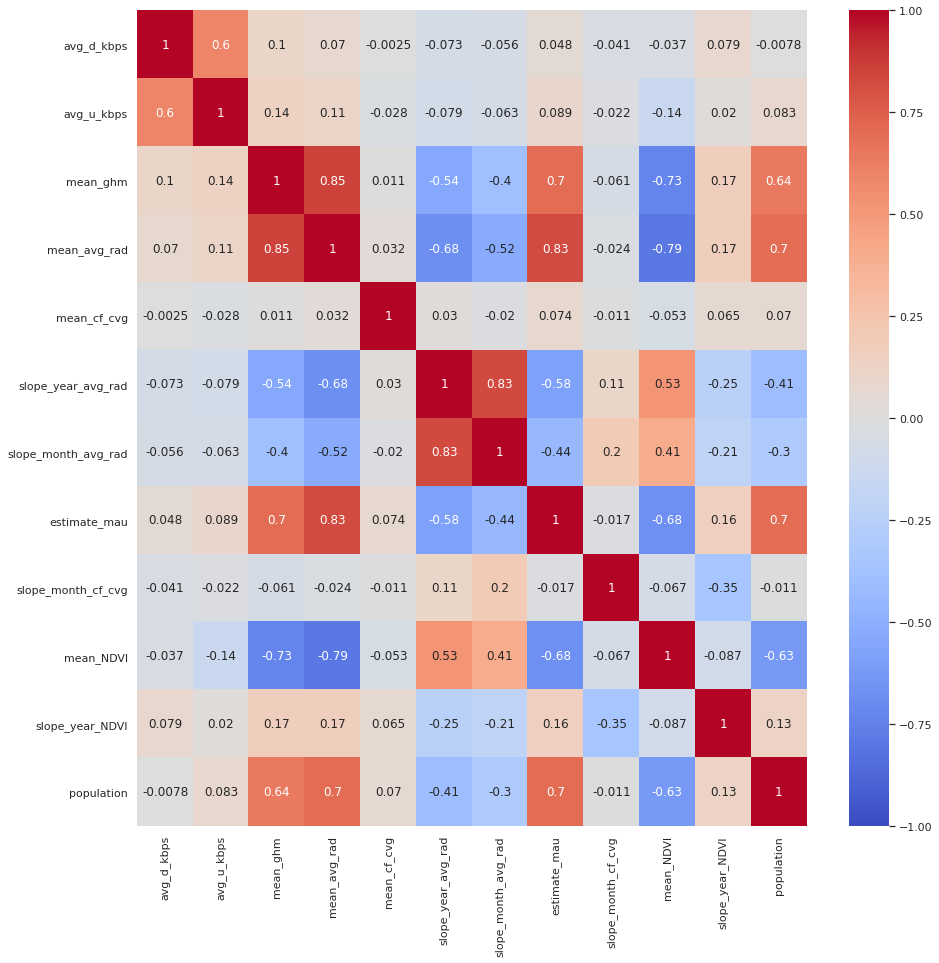

In [74]:
import seaborn as sns

sns.set(rc={'figure.figsize':(15,15)})

sns.heatmap(
    X.corr(), 
    cmap="coolwarm", 
    annot=True, 
    vmin=-1, 
    vmax=1,
)

## Training

### Prepare model tuning

In [141]:
# create inner and outer cross-validation sets
inner_cv = KFold(n_splits = model_config['parameter']['inner_cv'], shuffle=True)

# define parameter grid
parameters = {"n_estimators":  model_config['parameter']['Random_Forest']['n_estimators'],
              "max_depth": model_config['parameter']['Random_Forest']['n_estimators']}

# define model class to use
model = RandomForestRegressor(random_state=42)

#Create custom scoring
from sklearn.metrics import make_scorer

def custom_eval_metric(y_true, y_pred):
    #errors_low_ytest = abs(y_pred[np.asarray(y_true).flatten()<0.3] - np.asarray(y_true[np.asarray(y_true).flatten()<0.3]).flatten())
    errors_low=abs(y_pred[y_pred<model_config['parameter']['threshold']] - np.asarray(y_true[y_pred<model_config['parameter']['threshold']]).flatten())
    return np.mean(errors_low)
    
custom_scorer = make_scorer(custom_eval_metric, greater_is_better = False)

## Can use either randomized or grid search, use gridsearch for now but randomized when you have a larger parameter space
## define grid search
# search = RandomizedSearchCV(model, parameters, cv = inner_cv, random_state = 42,
# verbose = 2, n_iter = model_config['parameter']['iterations'],
# scoring = custom_scorer)

##define grid search
search = GridSearchCV(model, parameters, scoring = custom_scorer, cv = inner_cv ,
                            refit=True,
                            verbose = 2)


### Model tuning

In [142]:
# find best parameters
search.fit(X_train, y_train.values.ravel())

Fitting 10 folds for each of 16 candidates, totalling 160 fits
[CV] END ........................max_depth=4, n_estimators=4; total time=   0.1s
[CV] END ........................max_depth=4, n_estimators=4; total time=   0.1s


/opt/anaconda3/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/opt/anaconda3/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


[CV] END ........................max_depth=4, n_estimators=4; total time=   0.1s
[CV] END ........................max_depth=4, n_estimators=4; total time=   0.1s
[CV] END ........................max_depth=4, n_estimators=4; total time=   0.1s


/opt/anaconda3/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


[CV] END ........................max_depth=4, n_estimators=4; total time=   0.1s
[CV] END ........................max_depth=4, n_estimators=4; total time=   0.1s
[CV] END ........................max_depth=4, n_estimators=4; total time=   0.1s


/opt/anaconda3/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


[CV] END ........................max_depth=4, n_estimators=4; total time=   0.1s
[CV] END ........................max_depth=4, n_estimators=4; total time=   0.1s
[CV] END ........................max_depth=4, n_estimators=5; total time=   0.1s


/opt/anaconda3/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


[CV] END ........................max_depth=4, n_estimators=5; total time=   0.1s
[CV] END ........................max_depth=4, n_estimators=5; total time=   0.1s


/opt/anaconda3/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/opt/anaconda3/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


[CV] END ........................max_depth=4, n_estimators=5; total time=   0.1s
[CV] END ........................max_depth=4, n_estimators=5; total time=   0.1s
[CV] END ........................max_depth=4, n_estimators=5; total time=   0.1s
[CV] END ........................max_depth=4, n_estimators=5; total time=   0.1s


/opt/anaconda3/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/opt/anaconda3/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


[CV] END ........................max_depth=4, n_estimators=5; total time=   0.1s
[CV] END ........................max_depth=4, n_estimators=5; total time=   0.1s


/opt/anaconda3/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


[CV] END ........................max_depth=4, n_estimators=5; total time=   0.1s
[CV] END ........................max_depth=4, n_estimators=6; total time=   0.1s
[CV] END ........................max_depth=4, n_estimators=6; total time=   0.1s
[CV] END ........................max_depth=4, n_estimators=6; total time=   0.1s
[CV] END ........................max_depth=4, n_estimators=6; total time=   0.1s


/opt/anaconda3/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


[CV] END ........................max_depth=4, n_estimators=6; total time=   0.1s
[CV] END ........................max_depth=4, n_estimators=6; total time=   0.1s
[CV] END ........................max_depth=4, n_estimators=6; total time=   0.1s
[CV] END ........................max_depth=4, n_estimators=6; total time=   0.1s


/opt/anaconda3/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


[CV] END ........................max_depth=4, n_estimators=6; total time=   0.1s
[CV] END ........................max_depth=4, n_estimators=6; total time=   0.1s


/opt/anaconda3/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


[CV] END .......................max_depth=4, n_estimators=15; total time=   0.3s


/opt/anaconda3/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


[CV] END .......................max_depth=4, n_estimators=15; total time=   0.3s
[CV] END .......................max_depth=4, n_estimators=15; total time=   0.3s


/opt/anaconda3/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


[CV] END .......................max_depth=4, n_estimators=15; total time=   0.3s
[CV] END .......................max_depth=4, n_estimators=15; total time=   0.3s
[CV] END .......................max_depth=4, n_estimators=15; total time=   0.3s
[CV] END .......................max_depth=4, n_estimators=15; total time=   0.3s


/opt/anaconda3/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


[CV] END .......................max_depth=4, n_estimators=15; total time=   0.3s
[CV] END .......................max_depth=4, n_estimators=15; total time=   0.3s
[CV] END .......................max_depth=4, n_estimators=15; total time=   0.3s
[CV] END ........................max_depth=5, n_estimators=4; total time=   0.1s
[CV] END ........................max_depth=5, n_estimators=4; total time=   0.1s
[CV] END ........................max_depth=5, n_estimators=4; total time=   0.1s
[CV] END ........................max_depth=5, n_estimators=4; total time=   0.1s
[CV] END ........................max_depth=5, n_estimators=4; total time=   0.1s


/opt/anaconda3/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


[CV] END ........................max_depth=5, n_estimators=4; total time=   0.1s
[CV] END ........................max_depth=5, n_estimators=4; total time=   0.1s
[CV] END ........................max_depth=5, n_estimators=4; total time=   0.1s


/opt/anaconda3/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


[CV] END ........................max_depth=5, n_estimators=4; total time=   0.1s
[CV] END ........................max_depth=5, n_estimators=4; total time=   0.1s
[CV] END ........................max_depth=5, n_estimators=5; total time=   0.1s
[CV] END ........................max_depth=5, n_estimators=5; total time=   0.1s
[CV] END ........................max_depth=5, n_estimators=5; total time=   0.1s
[CV] END ........................max_depth=5, n_estimators=5; total time=   0.1s


/opt/anaconda3/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


[CV] END ........................max_depth=5, n_estimators=5; total time=   0.1s
[CV] END ........................max_depth=5, n_estimators=5; total time=   0.1s
[CV] END ........................max_depth=5, n_estimators=5; total time=   0.1s
[CV] END ........................max_depth=5, n_estimators=5; total time=   0.1s


/opt/anaconda3/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


[CV] END ........................max_depth=5, n_estimators=5; total time=   0.1s
[CV] END ........................max_depth=5, n_estimators=5; total time=   0.1s
[CV] END ........................max_depth=5, n_estimators=6; total time=   0.1s
[CV] END ........................max_depth=5, n_estimators=6; total time=   0.1s
[CV] END ........................max_depth=5, n_estimators=6; total time=   0.1s
[CV] END ........................max_depth=5, n_estimators=6; total time=   0.1s
[CV] END ........................max_depth=5, n_estimators=6; total time=   0.1s
[CV] END ........................max_depth=5, n_estimators=6; total time=   0.1s
[CV] END ........................max_depth=5, n_estimators=6; total time=   0.1s
[CV] END ........................max_depth=5, n_estimators=6; total time=   0.1s
[CV] END ........................max_depth=5, n_estimators=6; total time=   0.1s
[CV] END ........................max_depth=5, n_estimators=6; total time=   0.1s
[CV] END ...................

/opt/anaconda3/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


[CV] END .......................max_depth=5, n_estimators=15; total time=   0.4s
[CV] END .......................max_depth=5, n_estimators=15; total time=   0.4s


/opt/anaconda3/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


[CV] END .......................max_depth=5, n_estimators=15; total time=   0.4s
[CV] END .......................max_depth=5, n_estimators=15; total time=   0.4s
[CV] END .......................max_depth=5, n_estimators=15; total time=   0.4s
[CV] END .......................max_depth=5, n_estimators=15; total time=   0.4s
[CV] END .......................max_depth=5, n_estimators=15; total time=   0.4s
[CV] END ........................max_depth=6, n_estimators=4; total time=   0.1s
[CV] END ........................max_depth=6, n_estimators=4; total time=   0.1s
[CV] END ........................max_depth=6, n_estimators=4; total time=   0.1s
[CV] END ........................max_depth=6, n_estimators=4; total time=   0.1s
[CV] END ........................max_depth=6, n_estimators=4; total time=   0.1s
[CV] END ........................max_depth=6, n_estimators=4; total time=   0.1s
[CV] END ........................max_depth=6, n_estimators=4; total time=   0.1s
[CV] END ...................

/opt/anaconda3/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


[CV] END .......................max_depth=6, n_estimators=15; total time=   0.4s
[CV] END .......................max_depth=6, n_estimators=15; total time=   0.4s
[CV] END .......................max_depth=6, n_estimators=15; total time=   0.4s
[CV] END .......................max_depth=6, n_estimators=15; total time=   0.4s
[CV] END .......................max_depth=6, n_estimators=15; total time=   0.4s
[CV] END .......................max_depth=15, n_estimators=4; total time=   0.2s
[CV] END .......................max_depth=15, n_estimators=4; total time=   0.2s
[CV] END .......................max_depth=15, n_estimators=4; total time=   0.2s
[CV] END .......................max_depth=15, n_estimators=4; total time=   0.2s
[CV] END .......................max_depth=15, n_estimators=4; total time=   0.2s
[CV] END .......................max_depth=15, n_estimators=4; total time=   0.2s
[CV] END .......................max_depth=15, n_estimators=4; total time=   0.2s
[CV] END ...................

/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_search.py:918: UserWarning: One or more of the test scores are non-finite: [        nan         nan         nan         nan         nan         nan
 -0.22542679         nan -0.2373311  -0.20793853 -0.22594321         nan
 -0.14863422 -0.14496094 -0.14288592 -0.12780168]
  warnings.warn(


GridSearchCV(cv=KFold(n_splits=10, random_state=None, shuffle=True),
             estimator=RandomForestRegressor(random_state=42),
             param_grid={'max_depth': [4, 5, 6, 15],
                         'n_estimators': [4, 5, 6, 15]},
             scoring=make_scorer(custom_eval_metric, greater_is_better=False),
             verbose=2)

### Tuning results

In [143]:
# all results
search.cv_results_
# best results
best_parameter = search.best_params_
print(best_parameter)

{'max_depth': 15, 'n_estimators': 15}


In [144]:
print(search.cv_results_)

{'mean_fit_time': array([0.07910135, 0.0982065 , 0.11717696, 0.28790522, 0.09567783,
       0.11873469, 0.14162459, 0.34995434, 0.11202571, 0.13834589,
       0.16678114, 0.40926919, 0.22247028, 0.27622738, 0.33125165,
       0.82284429]), 'std_fit_time': array([0.00054757, 0.00057304, 0.00047324, 0.00153448, 0.000497  ,
       0.00048053, 0.00053455, 0.0006884 , 0.00074375, 0.0003917 ,
       0.00098656, 0.00142268, 0.00157012, 0.00198704, 0.00261009,
       0.00620867]), 'mean_score_time': array([0.00200298, 0.00230398, 0.00218599, 0.00282063, 0.00200024,
       0.00215628, 0.00212386, 0.00288062, 0.00210047, 0.00209129,
       0.00227525, 0.00294757, 0.00250533, 0.00261865, 0.00280118,
       0.00419517]), 'std_score_time': array([9.40121341e-05, 2.91441787e-04, 6.05983911e-05, 9.70042079e-05,
       8.13428988e-05, 6.40603215e-05, 5.89370004e-05, 6.04334242e-05,
       7.92547970e-05, 5.62807496e-05, 6.06109970e-05, 3.98567128e-05,
       3.56372298e-05, 2.05566595e-05, 2.04081290e

In [145]:
print(search.best_score_)

-0.1278016798323091


### Fit model with best parameters

In [146]:
# define model class to use
model = RandomForestRegressor(random_state = 42,
                               n_estimators = best_parameter['n_estimators'],
                              max_depth = best_parameter['max_depth']
                              )

# find best parameters
model.fit(X_train, y_train.values.ravel())

RandomForestRegressor(max_depth=15, n_estimators=15, random_state=42)

In [147]:
y_test.values.ravel()

array([0.64628737, 0.75724209, 0.11095472, ..., 1.        , 0.7690012 ,
       0.2309988 ])

## Pickling the best model (also saved within mlflow as an artifact)

In [21]:
import pickle

In [41]:
#changing directory
os.chdir('/home/desktop3/itu/models/')
path = os.getcwd()
print(path)

/home/desktop3/itu/models


In [42]:
#Pickle the model
# save the model to disk
filename = 'RF_model.sav'
pickle.dump(model, open(filename, 'wb'))

## Evaluation

In [155]:
# predict holdout
#pred = model.predict(X_test)
y_pred = model.predict(X_test)

# Absolute error
errors = abs(y_pred - y_test.iloc[:,0].to_numpy())
avg_error = np.mean(errors)

#Low tail error
errors_low = abs(y_pred[y_pred<model_config['parameter']['threshold']] - np.asarray(y_test[y_pred<model_config['parameter']['threshold']]).flatten())

#Low tail error
errors_low_ytest = abs(y_pred[np.asarray(y_test).flatten()<model_config['parameter']['threshold']]
                       - np.asarray(y_test[np.asarray(y_test).flatten()<model_config['parameter']['threshold']]).flatten())

#avg error
avg_error_low = np.mean(errors_low)


#avg error
avg_error_low_ytest = np.mean(errors_low_ytest)

#standard deviation
stan_dev_low= np.std(errors_low)



print('errors: ', errors)
print('avg error: ', avg_error)
# print('Just the lower errors: ', errors_low)
print('Mean lower error: ', avg_error_low)
print('Mean ytest lower error: ', avg_error_low_ytest)
# print('y test error: ', errors_low_ytest)
print('Standard Dev of Low Error: ', stan_dev_low)

ValueError: operands could not be broadcast together with shapes (51,) (153,) 

## Examining the errors

In [85]:
#Checking to see the raw amount of school
print('The amount of schools predicted to be lower than 30%: ', len(pred[pred<.3]))
print('The amount of schools that are actually below 30%: ', len(y_test[y_test['target']<0.3]))

The amount of schools predicted to be lower than 30%:  10
The amount of schools that are actually below 30%:  127


In [86]:
#Creating y_test dataframe to merge back
y_test['Predictions']= pred.tolist()
y_test['Errors']= abs(y_test['target']-y_test['Predictions'])
y_test

target  Predictions    Errors
4217   0.646287     0.757242  0.110955
10753  0.603167     0.757242  0.154075
6862   0.861206     0.769001  0.092205
10890  1.000000     0.814451  0.185549
6422   0.701705     0.757242  0.055538
...         ...          ...       ...
11297  0.859788     0.757242  0.102546
7402   0.916813     0.769001  0.147812
5860   0.628346     0.625350  0.002995
7383   0.743563     0.701304  0.042260
5095   1.000000     0.769001  0.230999

[3520 rows x 3 columns]

In [87]:
#Only values where ground truth less than .3
onlygtvalues = y_test.loc[y_test['target']<.3]

In [100]:
# Merge y_test back into main df
df_merge = pd.merge(y_test, dataset, how= "inner", left_index=True, right_index=True)

In [101]:
High_Error_Schools = df_merge.loc[df_merge['Errors']>.3]
High_Error_Schools.shape

(257, 32)

In [102]:
High_Pred_Schools = df_merge.loc[df_merge['Predictions']>.7]
High_Pred_Schools

target_x  Predictions    Errors  source_school_id  latitude  longitude  \
4217   0.646287     0.757242  0.110955          33136424  -22.8980   -43.5612   
10753  0.603167     0.757242  0.154075          35191905  -23.6853   -46.7645   
6862   0.861206     0.769001  0.092205          41151321  -25.4652   -49.2637   
10890  1.000000     0.814451  0.185549          35201558  -23.6397   -46.5570   
6422   0.701705     0.757242  0.055538          35087658  -23.6506   -46.7752   
...         ...          ...       ...               ...       ...        ...   
2273   0.819661     0.757242  0.062418          26179563   -8.1382   -34.9738   
11297  0.859788     0.757242  0.102546          43293069  -30.1587   -51.1714   
7402   0.916813     0.769001  0.147812          50006304  -20.4430   -54.6207   
7383   0.743563     0.701304  0.042260          50023268  -20.5192   -54.6528   
5095   1.000000     0.769001  0.230999          35052462  -23.5477   -46.5314   

                           school_location  \
4217              POINT (-43.5612 -22.898)   
10753            POINT (-46.7645 -23.6853)   
6862             POINT (-49.2637 -25.4652)   
10890             POINT (-46.557 -23.6397)   
6422             POINT (-46.7752 -23.6506)   
...                                    ...   
2273   POINT (-34.9738 -8.138199999999999)   
11297            POINT (-51.1714 -30.1587)   
7402              POINT (-54.6207 -20.443)   
7383             POINT (-54.6528 -20.5192)   
5095             POINT (-46.5314 -23.5477)   

                                                geometry  target_y  mean_ghm  \
4217   POLYGON ((-43.5512 -22.898, -43.55124815273328...  0.646287  0.850619   
10753  POLYGON ((-46.7545 -23.6853, -46.7545481527332...  0.603167  0.820720   
6862   POLYGON ((-49.2537 -25.4652, -49.2537481527332...  0.861206  0.927893   
10890  POLYGON ((-46.547 -23.6397, -46.54704815273328...  1.000000  0.941395   
6422   POLYGON ((-46.7652 -23.6506, -46.7652481527332...  0.701705  0.905878   
...                                                  ...       ...       ...   
2273   POLYGON ((-34.9638 -8.138199999999999, -34.963...  0.819661  0.662177   
11297  POLYGON ((-51.1614 -30.1587, -51.1614481527332...  0.859788  0.654317   
7402   POLYGON ((-54.6107 -20.443, -54.61074815273328...  0.916813  0.838306   
7383   POLYGON ((-54.6428 -20.5192, -54.6428481527332...  0.743563  0.824927   
5095   POLYGON ((-46.5214 -23.5477, -46.5214481527332...  1.000000  0.937670   

       ...  slope_year_NDVI  change_month_NDVI  slope_month_NDVI  \
4217   ...        47.371039         -18.119513         -0.131301   
10753  ...        49.638491         360.960122          2.615653   
6862   ...        -3.049995         -43.557768         -0.315636   
10890  ...        44.330307         192.747505          1.396721   
6422   ...        44.500204         199.094558          1.442714   
...    ...              ...                ...               ...   
2273   ...        -1.000300        -529.923684         -3.840027   
11297  ...        32.973480         184.810163          1.339204   
7402   ...        -6.521056          42.282435          0.306394   
7383   ...       -21.618274         126.488789          0.916585   
5095   ...        41.812569         113.288040          0.820928   

       estimate_dau  estimate_mau  estimate_ready  range  avg_d_kbps  \
4217         286201        440000            True    1.0     13498.0   
10753        477677        740000            True    1.0     23018.0   
6862         501140        740000            True    1.0     43183.0   
10890        505241        750000            True    1.0     20768.0   
6422         605050        920000            True    1.0     19232.0   
...             ...           ...             ...    ...         ...   
2273         175496        280000            True    1.0      8060.0   
11297        100934        150000            True    1.0     28656.0   
7402         187619        280000            True    1.

In [103]:
df_merge.shape

(3520, 32)

In [104]:
#Creating a geodataframe
from shapely import wkt

df_merge['school_location'] = geopandas.GeoSeries.from_wkt(df_merge['school_location'])
gdf = geopandas.GeoDataFrame(df_merge, geometry='school_location')

In [107]:
#Subset by just low Ground truth values
Low_GT = gdf.loc[gdf['target_x']<.3]
Low_pred = gdf.loc[gdf['Predictions']<.3]

In [108]:
Low_GT.loc[Low_GT['Predictions']>.3]

target_x  Predictions    Errors  source_school_id  latitude  longitude  \
10884  0.226581     0.757242  0.530661          35463361  -23.6343   -46.7861   
3520   0.182751     0.660610  0.477858          32004257  -18.8462   -41.1259   
8076   0.226581     0.757242  0.530661          35906438  -23.6325   -46.7838   
2227   0.000000     0.757242  0.757242          26109255   -8.1487   -34.9350   
5216   0.283260     0.769001  0.485741          35237206  -23.4992   -46.4456   
...         ...          ...       ...               ...       ...        ...   
4954   0.000000     0.769001  0.769001          35052224  -23.4902   -46.6176   
5204   0.283260     0.769001  0.485741          35002872  -23.4999   -46.4548   
561    0.156091     0.354302  0.198211          15028712   -1.0963   -48.6672   
1162   0.288257     0.351950  0.063693          21029644   -2.8216   -42.8776   
2724   0.121238     0.492794  0.371555          29073073  -11.4377   -40.4247   

                   school_location  \
10884  POINT (-46.78610 -23.63430)   
3520   POINT (-41.12590 -18.84620)   
8076   POINT (-46.78380 -23.63250)   
2227    POINT (-34.93500 -8.14870)   
5216   POINT (-46.44560 -23.49920)   
...                            ...   
4954   POINT (-46.61760 -23.49020)   
5204   POINT (-46.45480 -23.49990)   
561     POINT (-48.66720 -1.09630)   
1162    POINT (-42.87760 -2.82160)   
2724   POINT (-40.42470 -11.43770)   

                                                geometry  target_y  mean_ghm  \
10884  POLYGON ((-46.7761 -23.6343, -46.7761481527332...  0.226581  0.881110   
3520   POLYGON ((-41.1159 -18.8462, -41.1159481527332...  0.182751  0.376236   
8076   POLYGON ((-46.7738 -23.6325, -46.7738481527332...  0.226581  0.885265   
2227   POLYGON ((-34.925 -8.1487, -34.92504815273328 ...  0.000000  0.770606   
5216   POLYGON ((-46.4356 -23.4992, -46.4356481527332...  0.283260  0.919346   
...                                                  ...       ...       ...   
4954   POLYGON ((-46.60760000000001 -23.4902, -46.607...  0.000000  0.913985   
5204   POLYGON ((-46.4448 -23.4999, -46.4448481527332...  0.283260  0.923450   
561    POLYGON ((-48.6572 -1.0963, -48.65724815273328...  0.156091  0.221789   
1162   POLYGON ((-42.8676 -2.8216, -42.86764815273328...  0.288257  0.251747   
2724   POLYGON ((-40.4147 -11.4377, -40.4147481527332...  0.121238  0.252865   

       ...  slope_year_NDVI  change_month_NDVI  slope_month_NDVI  \
10884  ...        46.104083         202.052343          1.464147   
3520   ...        51.010652         614.754626          4.454744   
8076   ...        46.598101         200.930922          1.456021   
2227   ...         7.016483        -477.589528         -3.460794   
5216   ...        45.165093         310.164783          2.247571   
...    ...              ...                ...               ...   
4954   ...        49.607272         130.863354          0.948285   
5204   ...        46.947221         285.283845          2.067274   
561    ...        -0.005057        -769.659676         -5.577244   
1162   ...        55.154046        1469.419944         10.647971   
2724   ...        68.665824       -2903.342207        -21.038712   

       estimate_dau  estimate_mau  estimate_ready  range  avg_d_kbps  \
10884        529637        800000            True    1.0     14617.0   
3520           2607          3800            True    1.0     29117.0   
8076         534820        810000            True    1.0     21332.0   
2227         288657        490000            True    1.0     19016.0   
5216         607192        940000            True    1.0     20874.0   
...             ...           ...             ...    ...         ...   
4954         371466        580000            True    1.0     31305.0   
5204         578935        890000            True    1.0     49289.0   
561            2083          3600            True    1.0     26178.0   
1162           1156          2700            True    1.0       459.0   
2724   

## Plotting the errors

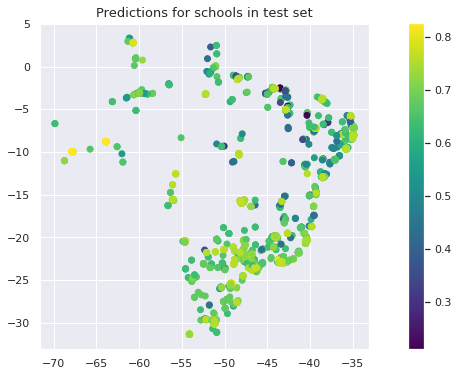

In [109]:
fig,ax =plt.subplots(1, figsize=(14,6))

# add a title and annotation
ax.set_title('Predictions for schools in test set', fontdict={'fontsize': '13', 'fontweight' : '3'})

gdf.plot(column="Predictions", cmap = 'viridis' ,legend=True, ax=ax)
# ctx.add_basemap(ax)

plt.show()

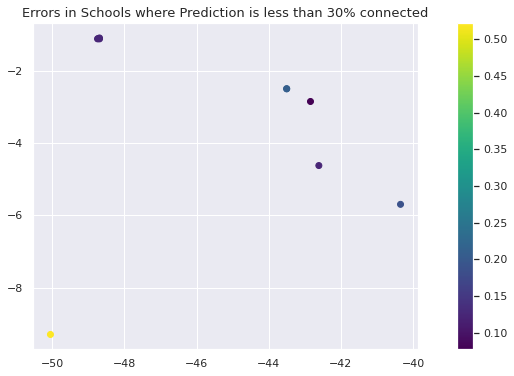

In [111]:
fig,ax =plt.subplots(1, figsize=(14,6))

# add a title and annotation
ax.set_title('Errors in Schools where Prediction is less than 30% connected', fontdict={'fontsize': '13', 'fontweight' : '3'})

#Do errors where ground truth is below .3 and also pred below .3
Low_pred.plot(column="Errors", cmap = 'viridis' ,legend=True, ax=ax)

plt.show()

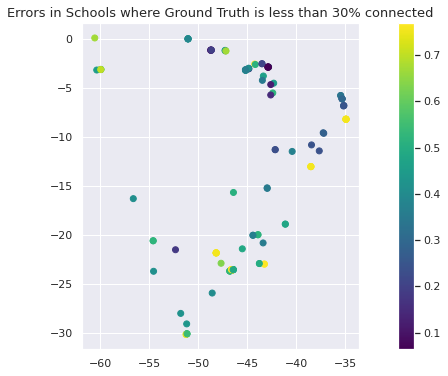

In [113]:
vmin, vmax= 0, .7

fig,ax =plt.subplots(1, figsize=(14,6))

# add a title and annotation
ax.set_title('Errors in Schools where Ground Truth is less than 30% connected', fontdict={'fontsize': '13', 'fontweight' : '3'})

#Do errors where ground truth is below .3 and also pred below .3
Low_GT.plot(column="Errors", cmap = 'viridis' ,legend=True, ax=ax)

plt.show()

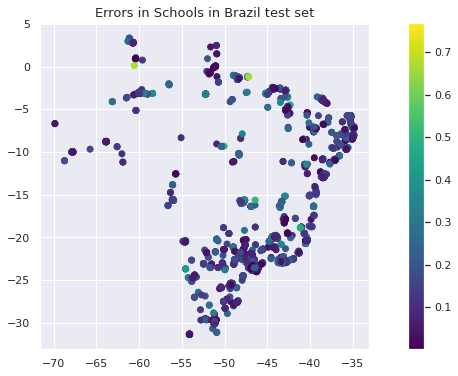

In [114]:
vmin, vmax= 0, .7

fig,ax =plt.subplots(1, figsize=(14,6))

# add a title and annotation
ax.set_title('Errors in Schools in Brazil test set', fontdict={'fontsize': '13', 'fontweight' : '3'})

gdf.plot(column="Errors", cmap = 'viridis' ,legend=True, ax=ax)

plt.show()

In [35]:
y = y_test.iloc[:,0].to_numpy()
y_pred = pred

fig = px.scatter(x=y, y=y_pred, labels={'x': 'ground truth', 'y': 'prediction'}, 
                 title = 'Comparison between predictions and reality',
                 template = 'plotly_dark')
fig.update_traces(marker=dict(size=3, 
                              color=((abs(y-y_pred) < 0.15).astype('int')),
                              colorscale=[[0, '#FAED27'],[1, '#98FB98']])
                             )
fig.add_shape(
    type="line", line=dict(dash='dash'),
    x0=y.min(), y0=y.min(),
    x1=y.max(), y1=y.max()
)
fig.show()

In [36]:
res_df = pd.DataFrame()
res_df['prediction'] = y_pred
res_df['ground truth'] = y
#res_df['train'] = y_train
res_df['residual'] = (pred - y_test.iloc[:,0].to_numpy())
fig = px.scatter(
    res_df, x='ground truth', y='residual',
    #marginal_y='violin',
    trendline='ols', template = 'plotly_dark',
    title = 'Comparison between residuals and reality'
)
fig.update_traces(marker=dict(size=3, 
                              color=((abs(res_df.residual) < 0.15).astype('int')),
                              colorscale=[[0, '#FAED27'],[1, '#98FB98']])
                             )
fig.show()

In [37]:
fig = px.scatter(
    res_df, x='prediction', y='residual',
    #marginal_y='violin',
    trendline='ols', template = 'plotly_dark',
    title = 'Comparison between residuals and predictions'
)
fig.update_traces(marker=dict(size=3, 
                              color=((abs(res_df.residual) < 0.15).astype('int')),
                              colorscale=[[0, '#FAED27'],[1, '#98FB98']])
                             )
fig.show()

In [38]:
online_pop = [pred, y_test.iloc[:,0].to_numpy()]
labels = ['predictions', 'reality']
         
fig = ff.create_distplot(online_pop, labels, show_hist = False)
fig.layout.update({'title':'Comparison of distributions of reality and predictions',
                   'title_font_color':'white',
                   'legend_bgcolor':'#545454',
                   'font_color':'white',
                   'plot_bgcolor':'#545454',
                   'paper_bgcolor':'#2a2a2a',
                   'yaxis':{'gridcolor':'#2a2a2a', 'zerolinecolor':'#2a2a2a'},
                   'xaxis':{'gridcolor':'#2a2a2a'}
                   })
fig.show()

## Model Interpretation
### Examining feature importances

In [115]:
# Make the dataframe
importance = pd.DataFrame(
    {"Feature": X.columns, "Importance": model.feature_importances_}
).sort_values("Importance")

In [116]:
importance

Feature  Importance
0            avg_d_kbps    0.000000
1            avg_u_kbps    0.006089
5    slope_year_avg_rad    0.011660
11           population    0.017606
8    slope_month_cf_cvg    0.026004
2              mean_ghm    0.033470
9             mean_NDVI    0.043408
6   slope_month_avg_rad    0.058660
4           mean_cf_cvg    0.115417
10      slope_year_NDVI    0.120491
7          estimate_mau    0.123015
3          mean_avg_rad    0.444180

<AxesSubplot:title={'center':'Feature Importances'}>

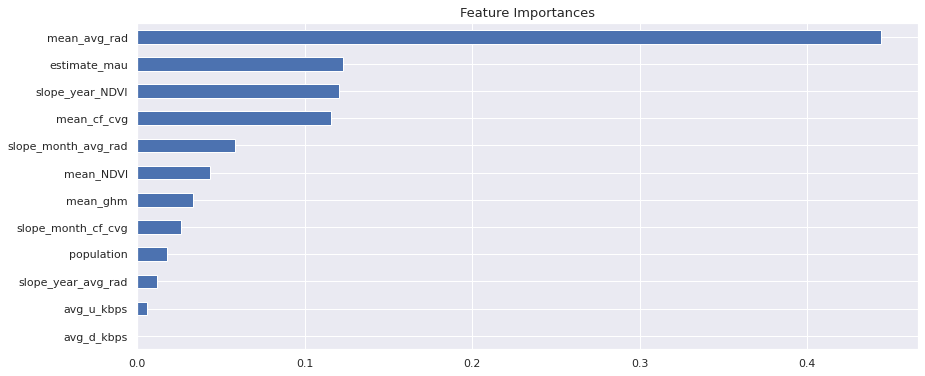

In [117]:
import matplotlib.pyplot as plt
fig,ax =plt.subplots(1, figsize=(14,6))

# add a title and annotation
ax.set_title('Feature Importances', fontdict={'fontsize': '13', 'fontweight' : '3'})

(pd.Series(model.feature_importances_, index=X.columns)
   .nsmallest(12).plot(kind='barh'))